# Import Packages

In [28]:
import pandas as pd
import json
import classes_functions as cf
import numpy as np
from pandarallel import pandarallel
import re
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

# Load Data

In [4]:
df = pd.DataFrame(columns=["shop", "url", "modelID", "featuresMap", "title"])

pandarallel.initialize(progress_bar=False)

# Load brand data https://www.kaggle.com/datasets/devsubhash/television-brands-ecommerce-dataset
brand_df = pd.read_csv("./TV_Final.csv")
brands_ref = [i.lower().strip() for i in brand_df[["Brand"]].drop_duplicates().to_numpy().flatten()] + ["nec", "insignia", "supersonic", "viewsonic", "vizio", "coby", 
                                                                                                    "naxa", "rca", "dynex", "magnavox", "sunbritetv", "avue", 
                                                                                                    "venturer", "pyle", "westinghouse", "proscan", "sceptre",
                                                                                                    "contex", "mitsubishi", 'epson', "hannspree", "curtisyoung",
                                                                                                    'hp', "seiki", "azend", "hiteker", "upstar", "optoma",
                                                                                                    "affinity", "viore", "craig", "elo", "gpx"
                                                                                                    ]
brand_pattern = '|'.join(rf'\b{re.escape(word)}\b' for word in brands_ref)
brand_regex_pattern = f'({brand_pattern})'

# Reading the json as a dict
with open("./TVs-all-merged.json") as json_data:
    df_dict = json.load(json_data)

for k, v in df_dict.items():
    df = pd.concat([df, pd.DataFrame(v)], ignore_index=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


# Prep Data

In [5]:
hertz_list = ['hertz', ' hz', '-hz', ' hertz']
inch_list = ['inches', ' inches', '"', ' "', '-inch', ' inch']

df["l_title"] = df["title"].str.lower()

df['l_title'] = df['l_title'].replace(hertz_list, 'hz', regex=True)
df['l_title'] = df['l_title'].replace(inch_list, 'inch', regex=True)
df['l_title'] = df['l_title'].replace("-", '', regex=True)

# Remove things in parenthesis (usually not the most important information)
parenthesis_regex = r'\([^)]*\)'
sq_bracket_refex = r'/\[.*\]/'
df['l_title'] = df['l_title'].replace(parenthesis_regex, '', regex=True)
df['l_title'] = df['l_title'].replace(sq_bracket_refex, '', regex=True)

regex_pattern = r'([a-zA-Z0-9]*(([0-9]+[^0-9, ]+)|([^0-9, ]+[0-9]+))[a-zA-Z0-9]*)'
matches = df['l_title'].str.extractall(regex_pattern).groupby(level=0)[0].apply(set).apply(lambda x: sorted(x))

df = df.merge(matches, how='left', left_index=True, right_index=True).rename(columns={0: 'main_feature_lst'})

brand_matches = df['l_title'].str.extractall(brand_regex_pattern).groupby(level=0)[0].apply(set).apply(lambda x: sorted(x))
df = df.merge(brand_matches, how='left', left_index=True, right_index=True).rename(columns={0: 'brand'})

df['appended_column'] = df.apply(lambda row: row['main_feature_lst'] + row['brand'] if not any(pd.isna(row)) else "", axis=1)
df['main_feature_w_id'] = df["appended_column"].apply(lambda x: ' '.join(map(str, x)))

id_regex = r'\b(?=\w*\d)(?=\w*[a-zA-Z])(?![\w\d]*(?:p|hz|inch|k|d)\b)(\w+)\b'
df["matched_id"] = df["main_feature_w_id"].str.findall(id_regex).apply(lambda x: max(x, default=np.nan, key=cf.get_length))
df['main_feature'] = df['main_feature_w_id'].astype(str).str.replace(' ', '')

# Main For-Loop

In [7]:
shingling_size = 3
hash_size = 8
train_frac = 0.63
nbr_runs = 10

# total_f1 = []
# total_f1_star = []
# bands = []
# fraction_of_comparisons = []

# for band_nbr in sorted(set([int(i) for i in np.logspace(1, 2.11, 100)])):

#     f1_list = []
#     f1_star_list = []
#     runtime_list = []
#     fraction_of_comparison_list = []

#     for i in tqdm(range(nbr_runs)):
#         f1, f1_star, confusion_matrix, all_pairs_without_dupes_test, runtime_sec, fraction_of_comparison = cf.main_run(df, train_frac, shingling_size, hash_size, band_nbr)
#         f1_list.append(f1)
#         f1_star_list.append(f1_star)
#         runtime_list.append(runtime_sec)
#         fraction_of_comparison_list.append(fraction_of_comparison)

#     total_f1.append(np.median(f1_list))
#     total_f1_star.append(np.median(f1_star_list))
#     fraction_of_comparisons.append(np.median(fraction_of_comparison_list))
#     bands.append(i)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

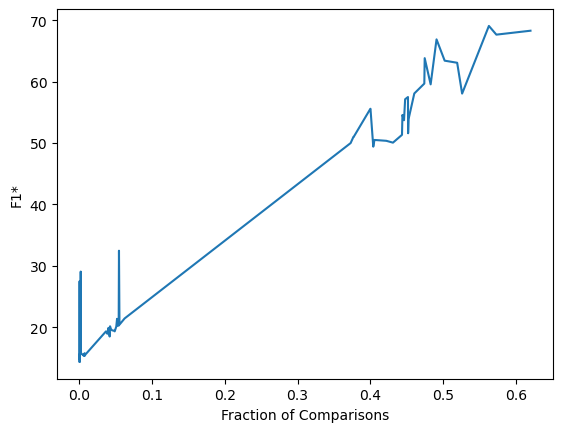

In [53]:
final_plotting_df = pd.read_csv("./plotting_data.csv", index_col=0)
final_plotting_df = final_plotting_df.rename(columns={'runtimime': 'runtime'})
final_plotting_df = final_plotting_df.sort_values("fractions")

plt.plot(final_plotting_df["fractions"], uniform_filter1d(final_plotting_df["runtime"], size=1))
plt.xlabel("Fraction of Comparisons")
plt.ylabel("F1*")
plt.show()